# Основы машинного обучения 
## НИУ ВШЭ

### Домашнее задание №8

In [2]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, mean_squared_error
from sklearn.model_selection import GridSearchCV
from collections import defaultdict

# Бустинг

## Градиентный бустинг своими руками (3 + 2* баллов)

Реализуйте алгоритм градиентного бустинга для регрессии. Напомним **основные формулы**.

Обозначим текущую композицию на $N-1$ шаге за $a_{N - 1}(x_i)$. Следующий базовый алгоритм $b_N(x_i)$ обучается на ответах $-\frac{\partial L(y_i, z)}{\partial z}\Bigl|_{z = a_{N - 1}(x_i)}$, где $L(y_i, z)$ — значение функции потерь на объекте при правильном ответе $y_i$ и предсказании $z$. Композиция на следующем шаге получается следующим образом:

$$
a_N(x_i) = a_{N-1}(x_i) + \nu\gamma_Nb_N(x_i)
$$

Здесь $\nu$ — гиперпараметр learning rate, $\gamma_N$ — оптимальный вес, настраиваемый на каждом шаге алгоритма, который можно найти по следующей формуле (обратите внимание на отсутствие $\nu$):

$$
\gamma_N = \mathrm{arg}\min_\gamma \frac{1}{\ell}\sum\limits_{i=1}^{\ell}L\left(y_i, a_{N - 1}(x_i) + \gamma b_N(x_i)\right)
$$

Можете принять $\gamma_N = 1$ для каждого $N$.

> Реализуйте нахождение оптимального $\gamma_N$ на каждом шаге, чтобы получить ещё 1 балл.


В качестве функции потерь возьмите **MSE**.

*Примечание. Вы можете использовать `DecisionTree` из `sklearn` и методы оптимизации из различных библиотек.*

ССЫЛКА НА ИСТОЧНИКИ: 

https://towardsdatascience.com/all-you-need-to-know-about-gradient-boosting-algorithm-part-1-regression-2520a34a502
очень помог этот код и объяснение для бустинга

https://datascience.stackexchange.com/questions/69092/how-to-minimize-mean-square-error-using-python
разобраться с minimize

In [6]:
# это может помочь вам для поиска оптимальных gamma
from scipy.optimize import minimize

In [ ]:
def mse(gamma, a, b, y):
    y_pred = b * gamma
    loss = np.mean((y - a - y_pred) ** 2)
    return loss

In [ ]:
class GradientBoosting:
    def __init__(self, n_estimators, max_depth, learning_rate=0.1, find_gamma=True):
        """
        PARAMETERS:
        n_estimators - number of trees in the ensemble
        max_depth - maximum depth of a tree
        learning_rate - coefficient by which new algorithm result is multiplied
        """
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.find_gamma = find_gamma

    def fit(self, x, y):
        """
        INPUT:
        x - np.array of shape (k, d)
        y - np.array of shape (k,)
        """
        # Здесь нам нужно проитерироваться по n_estimators и обучить
        # соответствующее количество деревьев с помощью _fit_predict_tree(),
        # правильно обновляя y_new
        # Деревья нужно где-то сохранить, чтобы затем использовать в predict()
        self.trees = []
        self.y_0 = np.mean(y)
        y_new = self.y_0
        self.gamma = 0.5
        
        for n in range(self.n_estimators):
            shift =  y - y_new
            tree, pred = self._fit_predict_tree(x, shift)
            if self.find_gamma:
                self.gamma = minimize(mse, [self.gamma,], args=(y_new, pred/(self.learning_rate * self.gamma), y)).x
            y_new += pred
            self.trees.append(tree)


    def _fit_predict_tree(self, x, y):
        # Обучаем дерево и возвращаем его предикшн
        tree = DecisionTreeRegressor(max_depth=self.max_depth, random_state=42)
        tree.fit(x, y)
        return tree, self.gamma * self.learning_rate * tree.predict(x)
        
    def predict(self, x):
        """
        INPUT:
        x - np.array of shape (m, d)
        OUTPUT:
        y_pred - np.array of shape (m,)
        """
        # Используем сохранённые деревья для расчёта агрегированного предикшна
        # your code here
        y_pred = self.y_0
        for i in range(self.n_estimators):
            y_pred += self.learning_rate * self.trees[i].predict(x)
        return y_pred
    
    def get_params(self, deep=True):
        out = dict()
        for key in self.__dict__:
            value = getattr(self, key)
            if deep and hasattr(value, "get_params"):
                deep_items = value.get_params().items()
                out.update((key + "__" + k, val) for k, val in deep_items)
            out[key] = value
        return out
    
    def set_params(self, **params):
        if not params:
            # Simple optimization to gain speed (inspect is slow)
            return self
        valid_params = self.get_params(deep=True)

        nested_params = defaultdict(dict)  # grouped by prefix
        for key, value in params.items():
            key, delim, sub_key = key.partition("__")
            if key not in valid_params:
                local_valid_params = self._get_param_names()
                raise ValueError(
                    f"Invalid parameter {key!r} for estimator {self}. "
                    f"Valid parameters are: {local_valid_params!r}."
                )

            if delim:
                nested_params[key][sub_key] = value
            else:
                setattr(self, key, value)
                valid_params[key] = value

        for key, sub_params in nested_params.items():
            valid_params[key].set_params(**sub_params)

        return self

Проверьте вашу реализацию на Boston dataset. 

> Подберите оптимальные гиперпараметры, чтобы победить RandomForestRegressor как в обычном случае, так и при нахождении оптимального шага **(не меняйте параметры сида)**. При необходимости воспользуйтесь GridSearch. За это вы получите ещё 1 балл.



In [ ]:
boston = load_boston()
X = boston.data
y = boston.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

d:\Programs\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_features=4, n_estimators=640, random_state=19052019)

rf.fit(X_train, y_train)
mean_squared_error(y_test, rf.predict(X_test))

9.63198271791959

In [ ]:
np.random.seed(19052019)

gb = GradientBoosting(max_depth=None, n_estimators=640)

gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)


In [ ]:
mean_squared_error(y_test, y_pred)

20.971575468853576

Найдем лучшие гиперпараметры с выбором оптимального шага:

In [ ]:
param = {
    "max_depth": np.arange(2, 10, 2),
    "n_estimators": np.arange(100, 1000, 100),
    "find_gamma": [True]
}

In [ ]:
search = GridSearchCV(
    estimator=GradientBoosting(max_depth=None, n_estimators=100, find_gamma=True),
    param_grid=param,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    cv=5
)
search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=<__main__.GradientBoosting object at 0x000002BA589E29A0>,
             n_jobs=-1,
             param_grid={'find_gamma': [True], 'max_depth': array([2, 4, 6, 8]),
                         'n_estimators': array([100, 200, 300, 400, 500, 600, 700, 800, 900])},
             scoring='neg_mean_squared_error')

In [ ]:
-search.best_score_, search.best_params_

(9.18231219963322, {'find_gamma': True, 'max_depth': 4, 'n_estimators': 100})

In [ ]:
gb = GradientBoosting(max_depth=4, n_estimators=100, find_gamma=True)
gb.fit(X_train, y_train)
mean_squared_error(y_test, gb.predict(X_test))

13.846750738666566

Теперь без выбора оптимального шага, по умолчанию gamma = 0.5

In [ ]:
param['find_gamma'] = [False]

search = GridSearchCV(
    estimator=GradientBoosting(max_depth=None, n_estimators=100, find_gamma=False),
    param_grid=param,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    cv=5
)
search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=<__main__.GradientBoosting object at 0x000002BA589E2C10>,
             n_jobs=-1,
             param_grid={'find_gamma': [False],
                         'max_depth': array([2, 4, 6, 8]),
                         'n_estimators': array([100, 200, 300, 400, 500, 600, 700, 800, 900])},
             scoring='neg_mean_squared_error')

In [ ]:
-search.best_score_, search.best_params_

(65.5167375885496, {'find_gamma': False, 'max_depth': 2, 'n_estimators': 100})

In [ ]:
gb = GradientBoosting(max_depth=2, n_estimators=100, find_gamma=False)
gb.fit(X_train, y_train)
mean_squared_error(y_test, gb.predict(X_test))

79.73096998379535

Можно заметить, что с выбором оптимального шага результат оказался лучше, но все же RandomForest не выиграл.

Для удобства проверяющего укажите, пожалуйста, реализовали ли вы нахождение оптимального шага?

- Да

## Прогнозируем задержки самолётов (2 балла)

Поработаем с задачей про задержки самолётов. На основании доступных данных о рейсе вам нужно определить, будет ли он задержан на 15 минут.
Воспользуйтесь любыми методами градиентного бустинга {`XGboost`, `catboost`, `LightGBM`} и `GridSearchCV` для достижения результата.

> Получите 1 балл за преодоление порога roc_auc_score 0.72 и ещё 1 балл за преодоление порога 0.74.



In [60]:
train = pd.read_csv('https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering-data/flight_delays_train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering-data/flight_delays_test.csv')

In [61]:
train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [62]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Month              100000 non-null  object
 1   DayofMonth         100000 non-null  object
 2   DayOfWeek          100000 non-null  object
 3   DepTime            100000 non-null  int64 
 4   UniqueCarrier      100000 non-null  object
 5   Origin             100000 non-null  object
 6   Dest               100000 non-null  object
 7   Distance           100000 non-null  int64 
 8   dep_delayed_15min  100000 non-null  object
dtypes: int64(2), object(7)
memory usage: 6.9+ MB


## Предобработка

In [63]:
print(np.unique(train['Month']), 
      np.unique(train['DayofMonth']),
      np.unique(train['DayOfWeek']))

['c-1' 'c-10' 'c-11' 'c-12' 'c-2' 'c-3' 'c-4' 'c-5' 'c-6' 'c-7' 'c-8'
 'c-9'] ['c-1' 'c-10' 'c-11' 'c-12' 'c-13' 'c-14' 'c-15' 'c-16' 'c-17' 'c-18'
 'c-19' 'c-2' 'c-20' 'c-21' 'c-22' 'c-23' 'c-24' 'c-25' 'c-26' 'c-27'
 'c-28' 'c-29' 'c-3' 'c-30' 'c-31' 'c-4' 'c-5' 'c-6' 'c-7' 'c-8' 'c-9'] ['c-1' 'c-2' 'c-3' 'c-4' 'c-5' 'c-6' 'c-7']


In [64]:
code_md = {f"c-{i}": i for i in range(32)}
train['Month'] = train['Month'].map(code_md).values
train['DayofMonth'] = train['DayofMonth'].map(code_md).values
train['DayOfWeek'] = train['DayOfWeek'].map(code_md).values

In [65]:
train = pd.concat([train, pd.get_dummies(train['UniqueCarrier'])], axis=1)

In [52]:
train.head()

,Month,DayofMonth,DayOfWeek,DepTime,Origin,Dest,Distance,dep_delayed_15min,AA,AQ,...,MQ,NW,OH,OO,TZ,UA,US,WN,XE,YV
0,8,21,7,1934,ATL,DFW,732,N,1,0,...,0,0,0,0,0,0,0,0,0,0
1,4,20,3,1548,PIT,MCO,834,N,0,0,...,0,0,0,0,0,0,1,0,0,0
2,9,2,5,1422,RDU,CLE,416,N,0,0,...,0,0,0,0,0,0,0,0,1,0
3,11,25,6,1015,DEN,MEM,872,N,0,0,...,0,0,0,1,0,0,0,0,0,0
4,10,7,6,1828,MDW,OMA,423,Y,0,0,...,0,0,0,0,0,0,0,1,0,0


## XGBoost

In [92]:
# Референс
from xgboost.sklearn import XGBClassifier

X_train = train.drop(['Origin', 'Dest', 'UniqueCarrier', 'dep_delayed_15min'], axis=1)
y_train = train['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values
X_test = test.drop(['Origin', 'Dest', 'UniqueCarrier'], axis=1).values
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size=0.3)

xgb = XGBClassifier(n_estimators=1000, max_depth=5)
xgb.fit(X_train_part, y_train_part)
roc_auc_score(y_valid, xgb.predict_proba(X_valid)[:, 1])

0.7400745909281606

GridSearch достаточно долго думал, так что мне было проще проверять подстановкой. Но если бы это было не так долго, я бы, конечно, посмотрел, что выдал бы GridSearchCv.

In [86]:
params_XGB = {
    'n_estimators': [200, 500, 1000],
    'max_depth' : [3, 5, 8],
    'learning_rate' : [0.1, 0.3]
}

In [87]:
search = GridSearchCV(
    estimator=XGBClassifier(),
    param_grid=params_XGB,
    cv=5,
    n_jobs=-1,
    scoring='roc_auc'
)

search.fit(X_train_part, y_train_part)
print(f"best param: {search.best_params_} \nbest roc_auc: {search.best_score_:,}")

KeyboardInterrupt: ignored

In [ ]:
best_cl = XGBClassifier().set_params(**search.best_params)
best_cl.fit(X_train_part, y_train_part)
y_pred = best_cl.predict(X_valid)
print(f"ROC-AUC on test set: {roc_auc_score(y_valid, y_pred)}")

# Кластеризация

## DBSCAN своими руками (3 + 2* баллов)


```
DBSCAN: Density-based spatial clustering of applications with noise
```


Реализуйте класс dbscan.

Алгоритм имеет два основных гиперпараметра:
1. `eps` &mdash; радиус рассматриваемой окрестности
2. `min_samples` &mdash; число соседей в окрестности

Для выполнения кластеризации DBSCAN точки делятся на основные точки, достижимые по плотности точки и выпадающие следующим образом:

- Точка $p$ является основной точкой, если по меньшей мере `min_samples` точек находятся на расстоянии, не превосходящем 
`eps` от неё. Говорят, что эти точки достижимы прямо из $p$.

-  Точка $q$ прямо достижима из $p$, если точка $q$ находится на расстоянии, не большем `eps`, от точки $p$, и $p$ — основная точка.
Точка $q$ достижима из $p$, если имеется путь 
$p_1,…,p_n$ где $p_1=p$ и $p_n=q$ , а каждая точка $p_{i+1}$ достижима прямо из $p_i$ (все точки на пути должны быть основными, за исключением $q$).

Все точки, не достижимые из основных точек, считаются выбросами.

Теперь, если $p$ является основной точкой, то она формирует кластер вместе со всеми точками (основными или неосновными), достижимыми из этой точки. Каждый кластер содержит по меньшей мере одну основную точку. Неосновные точки могут быть частью кластера, но они формируют его «край», поскольку не могут быть использованы для достижения других точек.


ИСТОЧНИК: https://en.wikipedia.org/wiki/DBSCAN
использовал код из википедии

In [93]:
# Это может помочь вам для поиска дистанции между точками
from scipy.spatial import distance

In [273]:
# Рекомендации -- это только рекомендации
class dbscan:
    def __init__(self, eps, min_samples):
        self.eps = eps
        self.min_samples = min_samples

        
    def fit_predict(self, X):
        # Помечаем переданные точки, чтобы отличать уже кластеризованные
        # или являющиеся шумом от остальных
        self.X = X
        self.y = np.zeros(X.shape[0])
        self.current_cluster = 0

        # Реализуем цикл по точкам, игнорирущий уже кластеризованные
        for i in range(len(X)):
            if self.y[i] == 0:
                # Если точка ещё не кластеризована, с помощью range_query() ищем её соседей
                neighbours = self.range_query(X[i])[0]
                # Если соседей недостаточно, то помечаем её выделенным под шум лейблом
                # (однако она ещё может попасть в какой-то иной кластер)
                if len(neighbours) < self.min_samples:
                    self.y[i] = -1
                else:
                    # Если же соседей достаточно, будем строить от неё кластер с помощью grow_cluster()
                    self.current_cluster += 1
                    self.y[i] = self.current_cluster
                    self.grow_cluster(i, neighbours)
        return self.y

    def grow_cluster(self, root, neighbours):
        # В этой функции мы полностью строим кластер относительно переданной точки
        # Т.е. реализуем цикл по структуре данных, изначально состоящей из уже
        # известных соседей (neighbours) и в процессе пополняющейся
        # "соседями соседей" с помощью range_query()
        neighbours = neighbours.tolist()
        for i in neighbours:
            self.y[i] = self.y[root]
            neigh_neigh = self.range_query(self.X[i])[0]
            if len(neigh_neigh) >= self.min_samples:
                neighbours += np.setdiff1d(neigh_neigh, neighbours).tolist()

    def range_query(self, x):
        """Возвращает точки на расстоянии <= eps от x"""
        # С помощью функции dist()
        return np.where(self.dist(self.X, x) <= self.eps)

    @staticmethod
    def dist(a, b):
        """Метрика расстояния"""
        return np.linalg.norm(a - b, axis=1)
        

Проверим себя на простом примере:

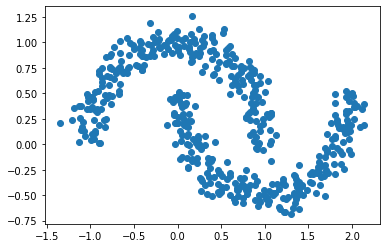

In [274]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import pandas as pd

X, _ = make_moons(n_samples=500, noise=0.1)
plt.scatter(X[:,0], X[:,1])
plt.show()

Кластеризуйте это с помощью своей версии DBSCAN:

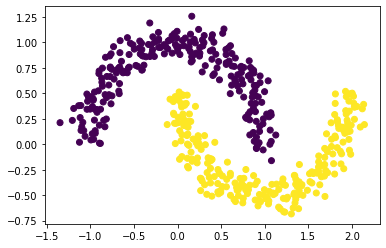

In [275]:
classifier = dbscan(eps=0.2, min_samples=10)
y_pred = classifier.fit_predict(X)
plt.scatter(X[:,0], X[:,1], c=y_pred)
plt.show()

Референс:

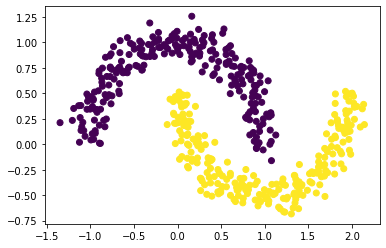

In [276]:
from sklearn.cluster import DBSCAN

clusters = DBSCAN(eps=0.2, min_samples=10).fit_predict(X)

plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()


> Получите ещё 1 балл, если время работы вашего алгоритма больше референсного не более чем в 100 раз с учётом погрешности 3% от вашего времени:



In [277]:
%%time
%%capture
clusters = DBSCAN(eps=0.2, min_samples=10).fit_predict(X)

CPU times: user 7.67 ms, sys: 0 ns, total: 7.67 ms
Wall time: 7.68 ms


In [278]:
%%time
%%capture
clusters = dbscan(eps=0.2, min_samples=10).fit_predict(X)

CPU times: user 43.8 ms, sys: 994 µs, total: 44.8 ms
Wall time: 44.8 ms


## Применяем DBSCAN (3 балла)

__[1.5 балла]__ Возьмите колонки `Distance` и `DepTime` (из датасета о задержках самолётов). Запустите на тренировочной выборке на них DBSCAN. Нарисуйте облоко рассеивания с получившимися кластерами. Насколько много их вышло? 

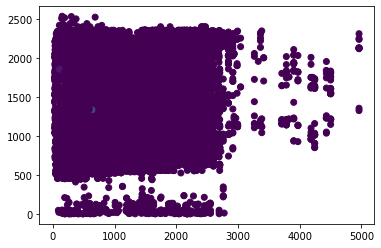

In [281]:
X = train[['Distance', 'DepTime']].values
clusters = DBSCAN().fit_predict(X)

plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()


Попробуйте перебрать параметры `eps` и `min_samples` по решётке и нарисовать для каждой пары облако рассеивания. При каких параметрах шумовых точек оказывается больше всего? Почему так происходит? 

__Ответ:__ 

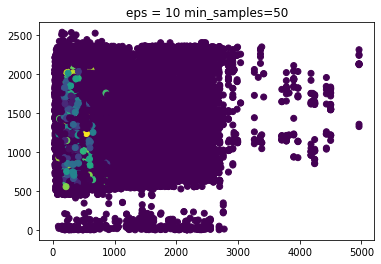

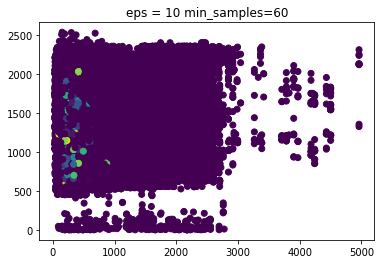

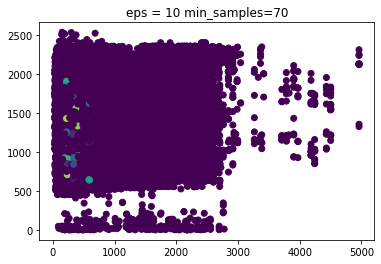

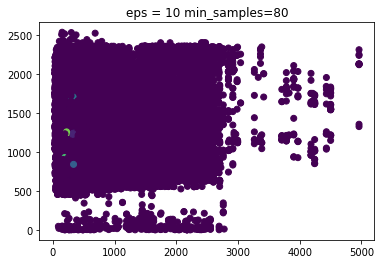

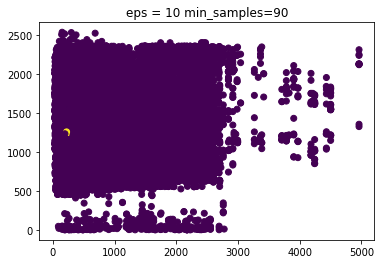

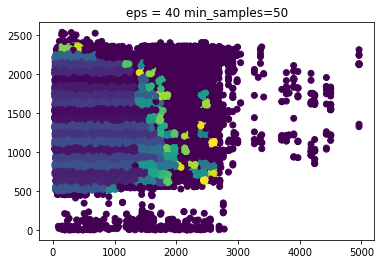

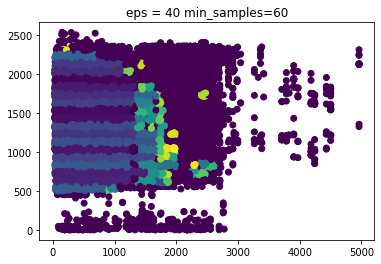

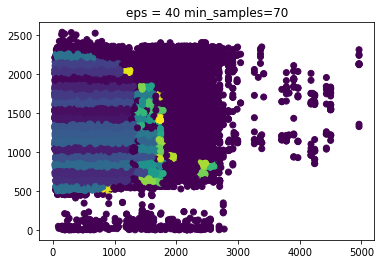

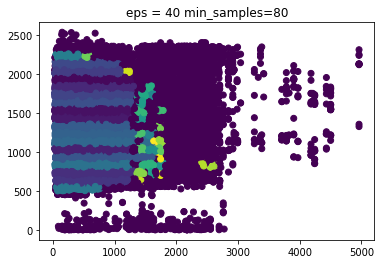

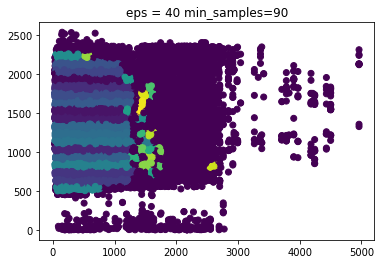

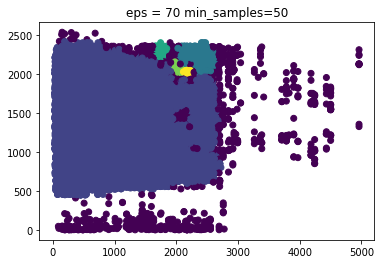

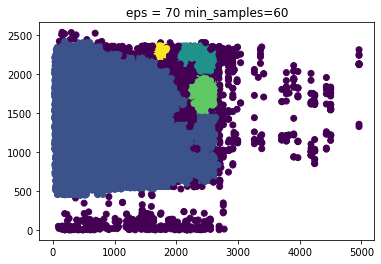

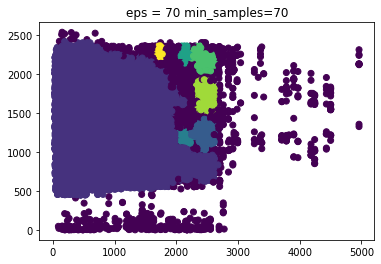

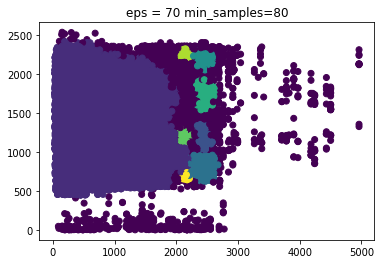

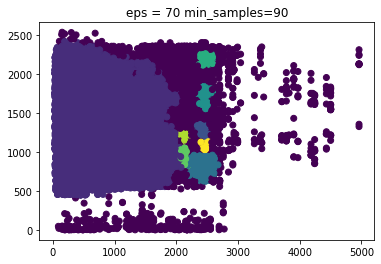

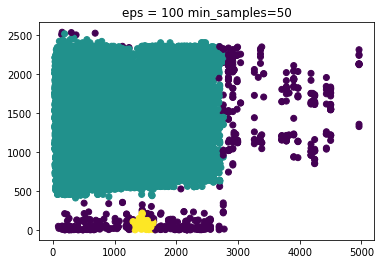

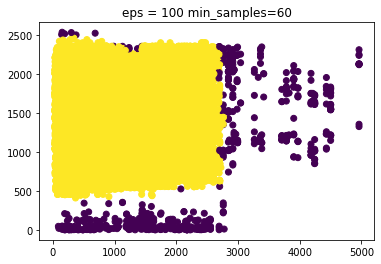

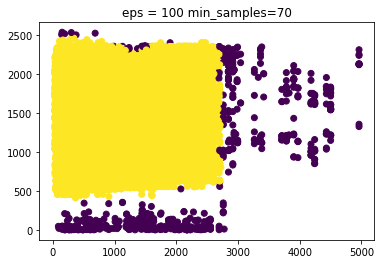

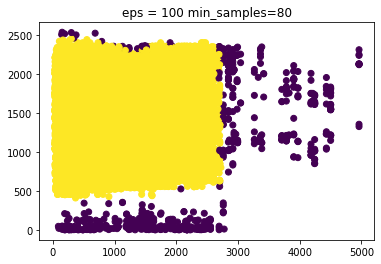

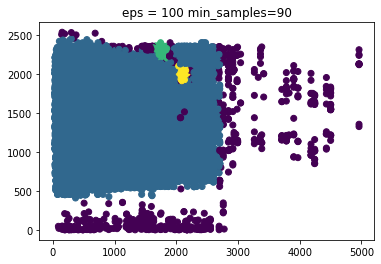

In [290]:
eps = np.arange(10, 130, 30)
min_samples = np.arange(50, 100, 10)

for e in eps:
    for ms in min_samples:
        clusters = DBSCAN(eps=e, min_samples=ms).fit_predict(X)

        plt.scatter(X[:,0], X[:,1], c=clusters)
        plt.title(f"eps = {e} min_samples={ms}")
        plt.show()


При параметрах eps=100, min_samples=70 можно заметить, что четко выделился квадрат. Это можно объяснить тем, что в нем находится очень высокая плотность точек (то есть уж 70-80 точек наберется чтобы захватить остальные), а до шумовых не доходит

__[1.5 балла]__ Добавьте в датасет новую категориальную переменную: номер кластера из DBSCAN и обучите Catboost со своими лучшими гиперпараметрами. Улучшилось ли качество модели на тестовой выборке? Как думаете, почему? 

In [330]:
X_train = train[['Distance', 'DepTime']].values

In [331]:
clusters = DBSCAN(eps=100, min_samples=70).fit_predict(X_train)
new_X = np.hstack((X_train, clusters.reshape(clusters.shape[0], -1)))
X_train_part, X_valid, y_train_part, y_valid = train_test_split(new_X, y_train, test_size=0.3)

In [314]:
from catboost import CatBoostClassifier

In [332]:
cb = CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=5, verbose=False)
cb.fit(X_train_part, y_train_part)
roc_auc_score(y_valid, cb.predict_proba(X_valid)[:, 1])

0.704619994074074

__Ответ:__ Если учесть, что в предыдущем задании я с помощью XGBoost выбил 0.74, то не сказать что улучшилось, ведь я использовал другие фичи, а тут только две. Можно попробовать использовать те же фичи как и в предыдущем задании и сравнить XGBoost и CatBoost с новой категориальной фичей в виде кластера от DBSCAN.

In [333]:
X_train = train.drop(['Origin', 'Dest', 'UniqueCarrier', 'dep_delayed_15min'], axis=1)
y_train = train['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values

new_X = np.hstack((X_train, clusters.reshape(clusters.shape[0], -1)))

X_train_part, X_valid, y_train_part, y_valid = train_test_split(new_X, y_train, test_size=0.3)

In [334]:
cb = CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=5, verbose=False)
cb.fit(X_train_part, y_train_part)
roc_auc_score(y_valid, cb.predict_proba(X_valid)[:, 1])

0.73793219245084